In [17]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

data = np.load("dataset.npy")

K = 3
N, D = data.shape

print(N, D)

300 2


# 1. Scatter Plot

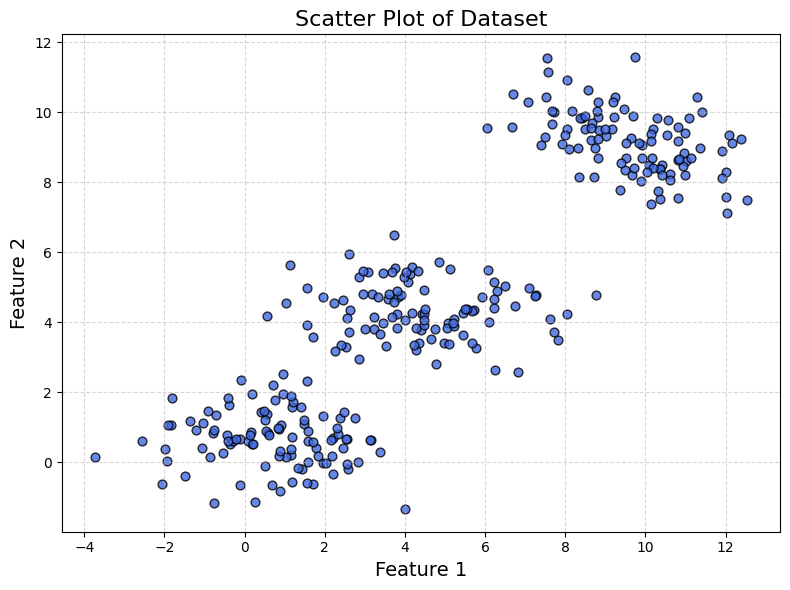

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c='royalblue', edgecolor='k', s=40, alpha=0.8)

plt.title("Scatter Plot of Dataset", fontsize=16)
plt.xlabel("Feature 1", fontsize=14)
plt.ylabel("Feature 2", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

# 2. Implementation

In [14]:
# --- Initialization ---
def init_mu():
    # random points
    return data[np.random.choice(N, K, replace=False)]

def init_cov():
    # using identity matrix initially
    return np.array([np.eye(D) for _ in range(K)])

def init_pi():
    # equal prob.
    return np.ones(K) / K

# --- Log-Likelihood Function---
def get_log_likelihood(mu, sigma, pi):
    log_likelihood = 0
    for n in range(N):
        prob = 0
        for k in range(K):
            prob += pi[k] * multivariate_normal.pdf(data[n], mean=mu[k], cov=sigma[k])
        log_likelihood += np.log(prob)
    return log_likelihood

# --- E-Step ---
def step_E(mu, sigma, pi):
    gamma = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            gamma[n, k] = pi[k] * multivariate_normal.pdf(data[n], mean=mu[k], cov=sigma[k])
        gamma[n, :] /= np.sum(gamma[n, :])
    return gamma

# --- M-Step Components ---
def compute_new_mu(gamma):
    Nk = np.sum(gamma, axis=0)
    mu = np.zeros((K, D))
    for k in range(K):
        mu[k] = np.sum(gamma[:, k].reshape(-1, 1) * data, axis=0) / Nk[k]
    return mu

def compute_new_sigma(gamma, mu):
    Nk = np.sum(gamma, axis=0)
    sigma = np.zeros((K, D, D))
    for k in range(K):
        diff = data - mu[k]
        weighted_sum = np.zeros((D, D))
        for n in range(N):
            weighted_sum += gamma[n, k] * np.outer(diff[n], diff[n])
        sigma[k] = weighted_sum / Nk[k]
    return sigma

def compute_new_pi(gamma):
    Nk = np.sum(gamma, axis=0)
    pi = Nk / N
    return pi

def step_M(gamma):
    # computing the new estimates
    mu = compute_new_mu(gamma)
    sigma = compute_new_sigma(gamma, mu)
    pi = compute_new_pi(gamma)
    return mu, sigma, pi

# --- EM Loop ---
def run_em(max_iters=100, tol=1e-4):
    mu = init_mu()
    sigma = init_cov()
    pi = init_pi()

    prev_log_likelihood = None
    for i in range(max_iters):
        gamma = step_E(mu, sigma, pi)
        mu, sigma, pi = step_M(gamma)
        log_likelihood = get_log_likelihood(mu, sigma, pi)

        print(f"Iteration {i+1}, Log-Likelihood: {log_likelihood:.4f}")
        if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return mu, sigma, pi, gamma

Iteration 1, Log-Likelihood: -1339.3068
Iteration 2, Log-Likelihood: -1312.1461
Iteration 3, Log-Likelihood: -1279.0521
Iteration 4, Log-Likelihood: -1272.3433
Iteration 5, Log-Likelihood: -1266.7684
Iteration 6, Log-Likelihood: -1259.5577
Iteration 7, Log-Likelihood: -1250.2661
Iteration 8, Log-Likelihood: -1239.9308
Iteration 9, Log-Likelihood: -1233.2351
Iteration 10, Log-Likelihood: -1231.7693
Iteration 11, Log-Likelihood: -1231.6907
Iteration 12, Log-Likelihood: -1231.6888
Iteration 13, Log-Likelihood: -1231.6887


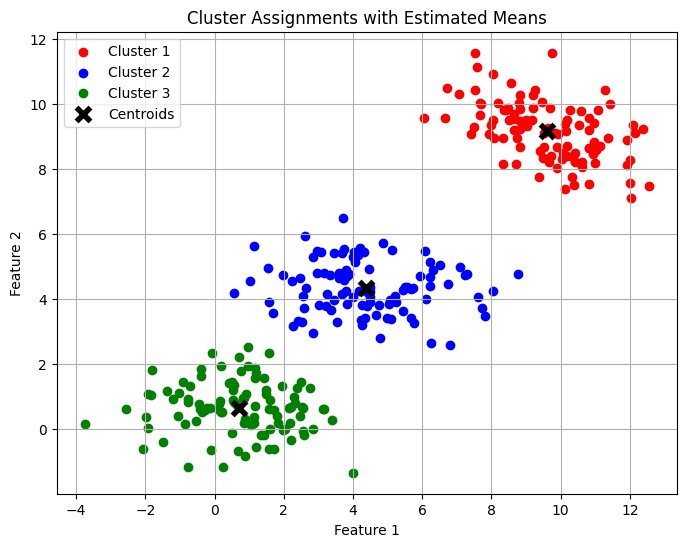

Estimated Means (µk):
[[9.60515914 9.16835945]
 [4.37899812 4.35180871]
 [0.702065   0.66132573]]

Estimated Covariances (Σk):
Covariance matrix for Cluster 1:
[[ 2.01245136 -0.64166751]
 [-0.64166751  0.82171149]]
Covariance matrix for Cluster 2:
[[ 2.74799004 -0.11914407]
 [-0.11914407  0.61810867]]
Covariance matrix for Cluster 3:
[[ 2.11798153 -0.09977404]
 [-0.09977404  0.64077187]]


In [50]:
mu, sigma, pi, gamma = run_em()

cluster_assignments = np.argmax(gamma, axis=1)

plt.figure(figsize=(8, 6))
colors = ['#FF0000', '#0000FF', '#008000']  # Red, Blue, Green
for k in range(K):
    # data points
    plt.scatter(data[cluster_assignments == k, 0], data[cluster_assignments == k, 1], label=f"Cluster {k+1}", color=colors[k])

# centroids
plt.scatter(mu[:, 0], mu[:, 1], c='black', s=100, marker='x', label='Centroids', linewidths=4)
plt.title("Cluster Assignments with Estimated Means")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

# estimated values for means and covariances
print("Estimated Means (µk):")
print(mu)

print("\nEstimated Covariances (Σk):")
for k in range(K):
    print(f"Covariance matrix for Cluster {k+1}:")
    print(sigma[k])

# 3. Plotting the Gaussians

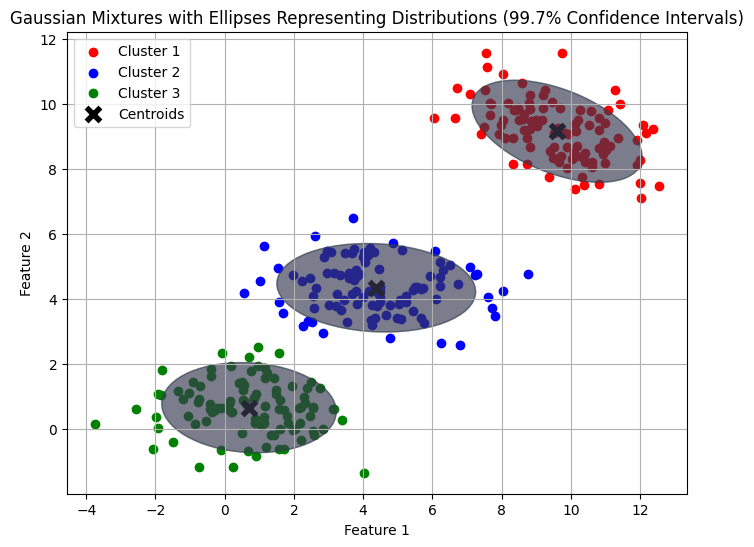

In [51]:
def plot_gaussian(mu, sigma, ax, color):
    confidence_level=3
    for k in range(K):
        # cov and mean for the k-th Gaussian
        cov = sigma[k]
        mean = mu[k]

        # eigenvalue decomposition to find the spread and orientation
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # angle of the ellipse from the eigenvector with the largest eigenvalue
        angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
        width, height = 2 * np.sqrt(confidence_level * eigenvalues)

        # creating the ellipse shape
        ell = Ellipse(mean, width, height, angle=angle, color=color, alpha=0.3)
        ax.add_patch(ell)

fig, ax = plt.subplots(figsize=(8, 6))

for k in range(K):
    # plotting the data points
    ax.scatter(data[cluster_assignments == k, 0], data[cluster_assignments == k, 1],
               label=f"Cluster {k+1}", color=colors[k])

# plotting centroids
ax.scatter(mu[:, 0], mu[:, 1], c='black', s=100, marker='x', label='Centroids', linewidths=4)

# plotting gaussian ellipses
for k in range(K):
    plot_gaussian(mu, sigma, ax, colors[k])

plt.title("Gaussian Mixtures with Ellipses Representing Distributions (99.7% Confidence Intervals)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()